# Fifteeen years of flu in the US

**Note**: this exercise is based on the following tutorials:
* https://github.com/reconhub/phylo-practical
* https://grunwaldlab.github.io/Population_Genetics_in_R/DAPC.html

In this exercise you will learn:
* how to align DNA sequences
* how to calculate and display a matrix of genetic distances
* how to generate a phylogenetic tree
* how to analyze a lot of influenza virus isolates and find the genetic basis of their evolutionaries trajectories

Our data:
* 80 isolates of seasonal influenza (H3N2) genotyped for the hemagglutinin (HA) segment sampled in the US from 1993 to 2008


## Installing the required packages / downloading the required files

We install `seqinr` (to read/manage/write sequence data), `msa` (to perform multiple alignments) and `adegenet`, `ade4` (genomic analyses), `ape` (to generate/manipulate phylogenetic trees)

In [ ]:
# We tell R to use /bin/tar to decompress the files. Otherwise it will try to use /bin/gtar
# and the installation will fail
if (file.exists(Sys.getenv("TAR")) == FALSE)  {
    Sys.setenv(TAR = "/bin/tar")
}
# We install the required packages
install.packages("seqinr",dep=TRUE,repos="https://cran.r-project.org")
source("http://www.bioconductor.org/biocLite.R")
biocLite("msa")
install.packages(c("adegenet","ade4","ape"), dep=TRUE,repos="https://cran.r-project.org")

We download from github some data files that are needed for this tutorial (so you can learn how to download files from the Internet with `R`):

In [5]:
if (!dir.exists("data")) dir.create("data")
download.file("https://raw.githubusercontent.com/reconhub/phylo-practical/master/data/usflu.annot.csv", destfile = "data/usflu.annot.csv", method = "curl")
download.file("https://raw.githubusercontent.com/reconhub/phylo-practical/master/data/usflu.fasta", destfile = "data/usflu.fasta", method = "curl")

## Multiple sequence alignment
We load `seqinr` and `msa` and read the `.fasta` file containing the sequences we want to align:

In [36]:
library("seqinr")
library("msa")

sequences <- readDNAStringSet("data/usflu_orig.fasta")
sequences


Attaching package: ‘seqinr’


The following objects are masked from ‘package:ape’:

    as.alignment, consensus


Loading required package: Biostrings

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:ade4’:

    score


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Redu

ERROR: Error in .Call2("new_input_filexp", filepath, PACKAGE = "XVector"): cannot open file 'data/usflu_orig.fasta'


We perform the multiple sequence alignment:

In [382]:
alignment=msa(sequences, "Muscle")
alignment

MUSCLE 3.8.31   

Call:
   msa(sequences, "Muscle")

MsaDNAMultipleAlignment with 80 rows and 1701 columns
     aln                                                   names
 [1] ATGAAGACTATCATTGCTTTGAGCT...CATTAGATGCAACATTTGCATTTGA EU779500
 [2] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY035190
 [3] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU852005
 [4] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU779498
 [5] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU516212
 [6] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA FJ549055
 [7] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU199369
 [8] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA EU516036
 [9] -------------------------...CATTAGGTGCAACATTTGCATTTGA EU199254 
 ... ...
[73] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY013781
[74] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY013613
[75] ATGAAGACTATCATTGCTTTGAGCT...CATTAGGTGCAACATTTGCATTTGA CY012160
[7

We convert the alignment to a format that `seqinr` can manage and then we save it:

In [383]:
alignment_seqinr=msaConvert(alignment, "seqinr::alignment")

# We save the data
write.fasta(as.list(alignment_seqinr$seq),alignment_seqinr$nam,file="data/usflu_ali.fasta",as.string=TRUE)

## Distance matrix and phylogenetic tree
We load the libraries needed for the next steps of the analysis:

In [16]:
library(stats)
library(ade4)
library(ape)
library(adegenet)

Registered S3 method overwritten by 'spdep':
  method   from
  plot.mst ape 


   /// adegenet 2.1.2 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()





We load the alignment (converting it to `DNAbin` format, which is suitable to perform fast caculations. The `adegenet` provides a function to do this) and calculate a distance matrix (using the `ape` package):

In [17]:
dna <- fasta2DNAbin(file="data/usflu.fasta")


 Converting FASTA alignment into a DNAbin object... 


 Finding the size of a single genome... 


 genome size is: 1,701 nucleotides 

( 30  lines per genome )

 Importing sequences... 
........................................................................................................................................................................................................................................................................................................................................................................
 Forming final object... 

...done.



We load the annotations and have a look at them:

In [12]:
annot <- read.csv("data/usflu.annot.csv",
header=TRUE, row.names=1, stringsAsFactors=FALSE)
tail(annot,5)

,accession,year,misc
,<chr>,<int>,<chr>
76,FJ549055,2008,(A/Illinois/14/2008(H3N2))
77,EU779498,2008,(A/Mississippi/01/2008(H3N2))
78,EU779500,2008,(A/Indiana/02/2008(H3N2))
79,CY035190,2008,(A/Pennsylvania/PIT43/2008(H3N2))
80,EU852005,2008,(A/Texas/06/2008(H3N2))


How many strains do we have for each year?

In [13]:
table(annot$year)


1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 
   5    5    5    5    5    5    5    5    5    5    5    5    5    5    5    5 

We calculate the distances between all our isolates using the model `TN93`:

In [18]:
D <- dist.dna(dna, model="TN93")

We make a plot of the distance matrix:

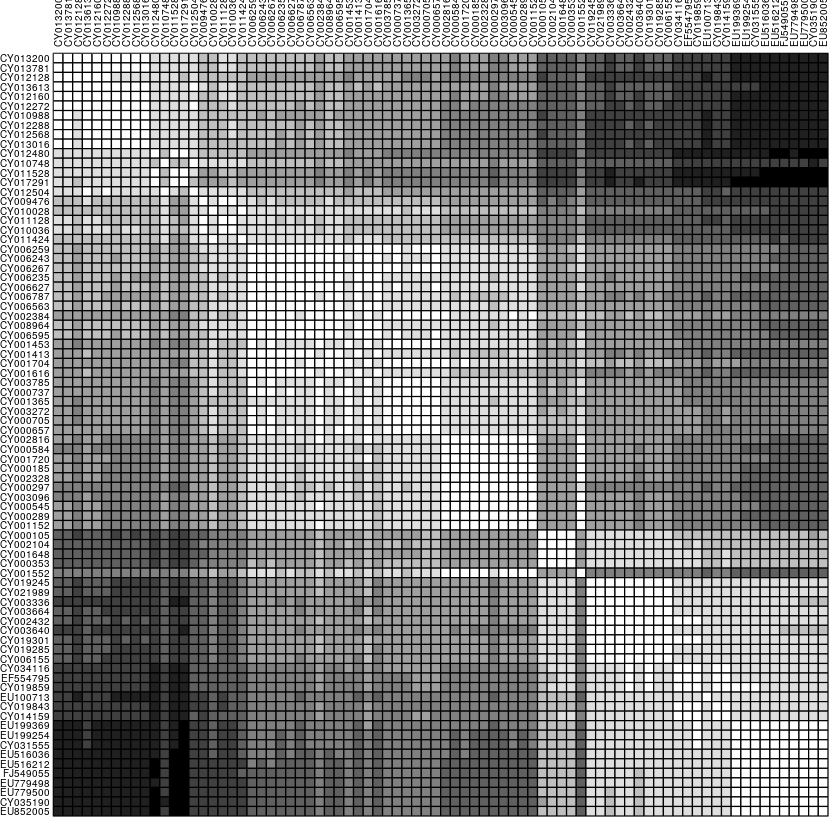

In [22]:
mat <- as.data.frame(as.matrix(D))
table.paint(mat, cleg=0, clabel.row=.5, clabel.col=.5)

What are the max and min distances?

In [23]:
min(mat)
max(mat)

[1] 0

[1] 0.08361022

We generate a phylogenetic tree using the Neighbour-Joining algorithm and we display it (note that the tree is unrooted!):

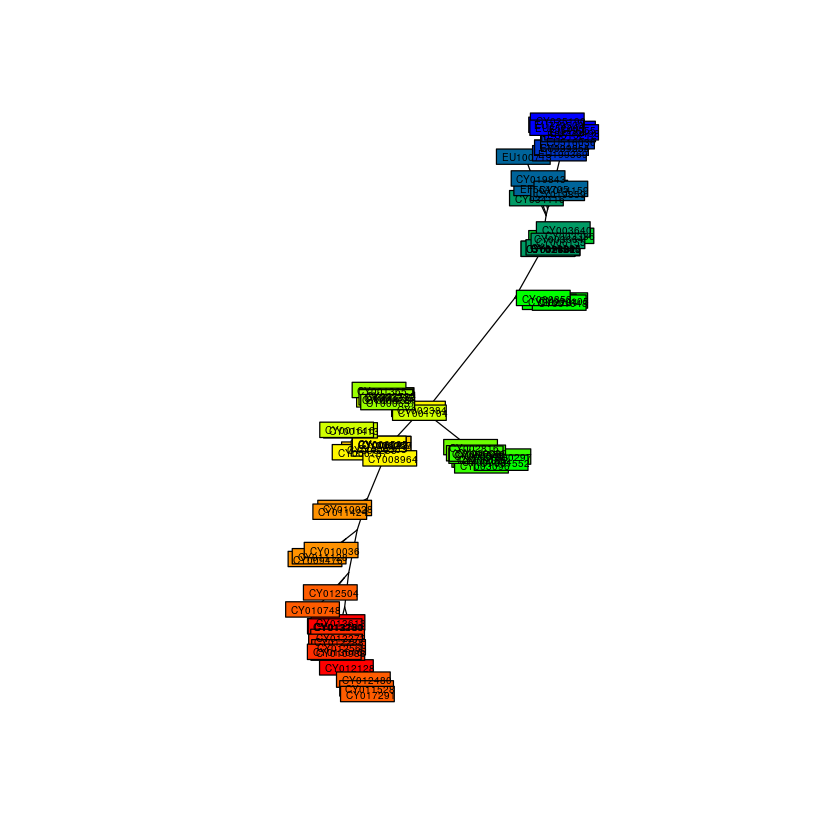

In [27]:
tre <- nj(D)
plot(tre, type="unrooted", show.tip=FALSE)
myPal <- colorRampPalette(c("red","yellow","green","blue"))
tiplabels(tre$tip.label, bg=num2col(annot$year, col.pal=myPal),
cex=.5)

We root the tree and display it again:

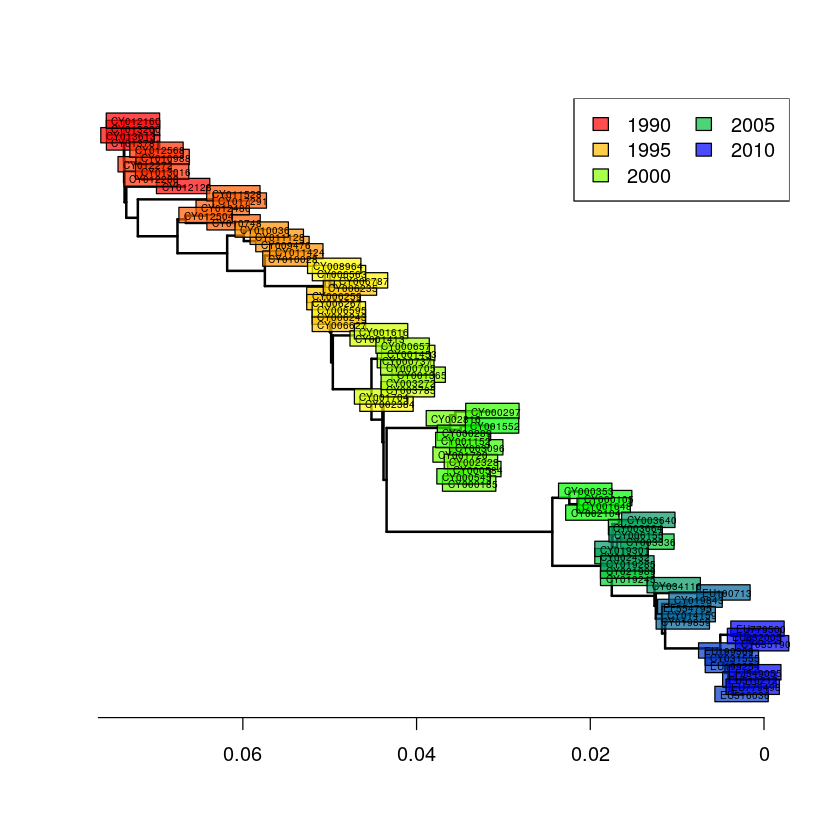

In [32]:
tre2 <- root(tre, out=1)
tre2 <- ladderize(tre2)
plot(tre2, show.tip=FALSE, edge.width=2)
tiplabels(tre$tip.label, bg=transp(num2col(annot$year, col.pal=myPal),.7),
cex=.5, fg="transparent")
axisPhylo()
temp <- pretty(1993:2008, 5)
legend("topright", fill=transp(num2col(temp, col.pal=myPal),.7),
leg=temp, ncol=2)

## Studying the genetic differences between these isolates

We load the data and convert them to a data structure that allows fast calculations:

In [84]:
h3n2_ali = read.alignment("data/usflu.fasta",format="fasta")
h3n2 = alignment2genind(h3n2_ali)

Warning message in df2genind(mat, pop = pop, ploidy = 1, ncode = 1, type = "codom"):
“duplicate labels detected for some individuals; using generic labels”


In [156]:
h3n2_ali

$nb
[1] 80

$nam
 [1] "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""
[26] "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""
[51] "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""
[76] "" "" "" "" ""

$seq
$seq[[1]]
[1] "atgaagactatcattgctttgagctacattttatgtctggttttcgctcaaaaacttcccggaaatgacaacagcacagcaacgctgtgcctgggacaccatgcagtgccaaacggaacgctagtgaaaacaatcacgaatgatcaaattgaagtgactaatgctactgagctggttcagagttcctcagcaggtagaatatgcgacagtcctcaccgaatccttgatggaaaaaactgcacactgatagatgctctattgggagaccctcattgtgatggcttccaaaataaggaatgggacctttttgttgaacgcagcaaagcttacagcaactgttacccttatgatgtgccggattatgcctcccttaggtcactagttgcctcatcaggcaccctggagtttatcaatgaagacttcaattggactggagtcgctcaggatgggaaaagctatgcttgcaaaaggggatctgttaacagtttctttagtagattgaattggttgcacaaattagaatacaaatatccagcgctgaacgtgactatgccaaacaatggcaaatttgacaaattgtacatttggggggttcaccacccgagcacggacagtgaccaaaccagcctatatgttcgagcatcagggagagtcacagtctctaccaaaagaagccaacaaactgtaatcccgaatatcggg

We define the different classes (populations). In this case they are the isolates sampled in different years:

In [85]:
pop(h3n2) <- annot$year

We perform a DAPC analysis:

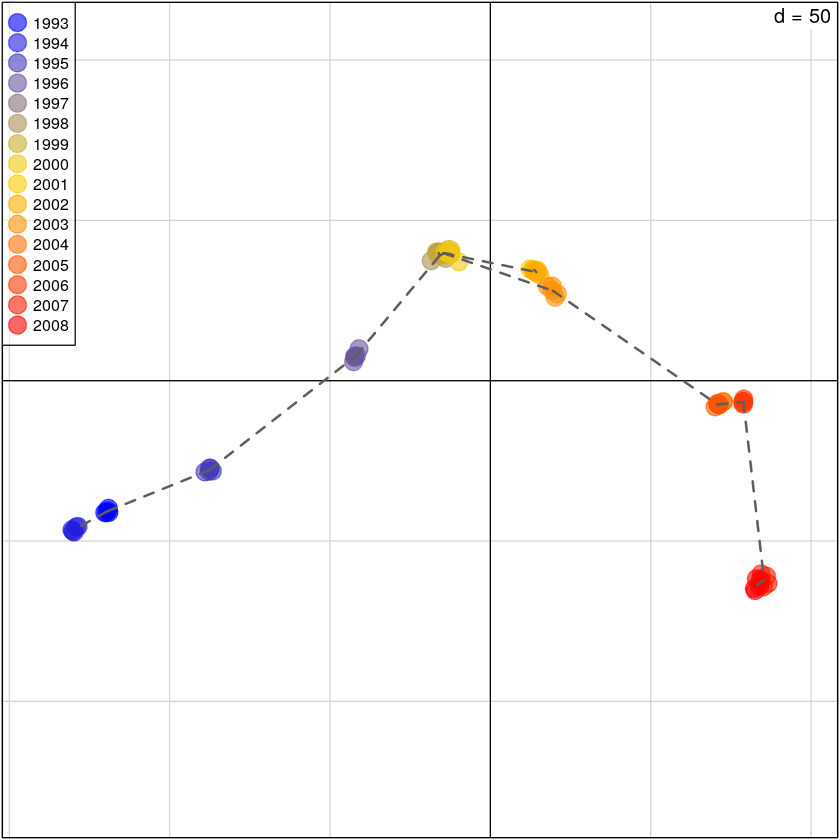

In [86]:
# If you want to know more about the DAPC, please have a look at this: https://doi.org/10.1186/1471-2156-11-94
dapc.h3n2 <- dapc(h3n2, var.contrib = TRUE, scale = FALSE, n.pca = 30, n.da = nPop(h3n2) - 1)
scatter(dapc.h3n2,xax=1,yax=2,scree.da=F,cell=0, pch = 19, cstar = 0, solid=0.6,cex=2,clab=0,mstree=T,lty=2,lwd=2,leg=T,posi.leg="topleft",segcol="grey37",grid=T,cleg=0.8)
# Have a look at this web site if you want to know more about the parameters of the scatter function: 
# https://www.rdocumentation.org/packages/adegenet/versions/2.0.1/topics/dapc%20graphics

Now let's repeat the same analysis, but focusing on a specific time frame (2006-2008):

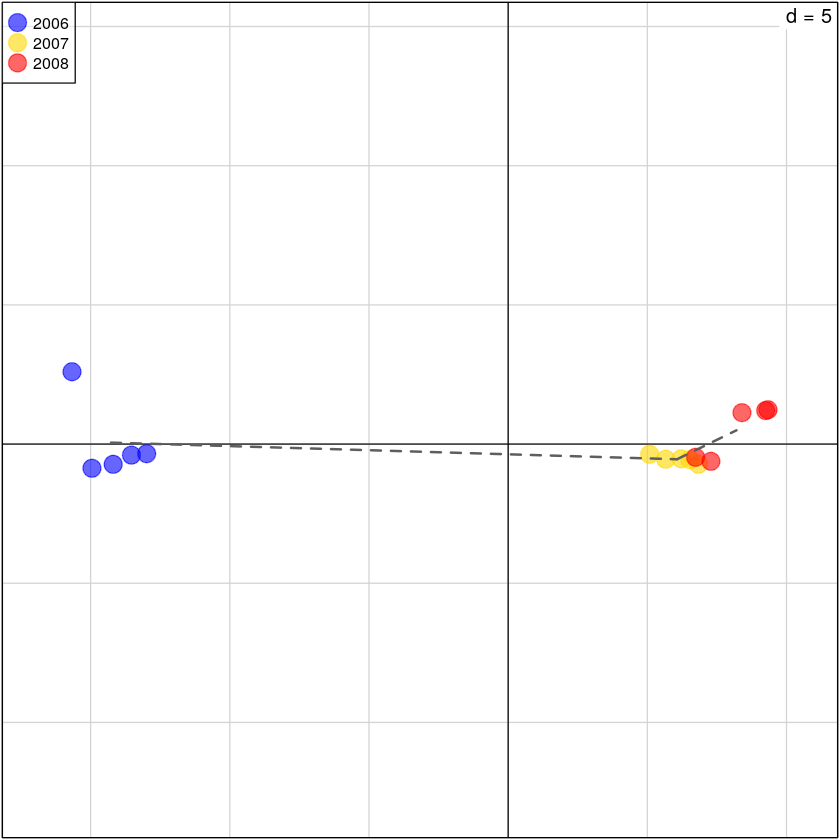

In [155]:
idx_selected_seqs=which(as.vector(h3n2@pop) %in% as.character(2006:2008))
h3n2_mini=h3n2[idx_selected_seqs]
dapc_h3n2_mini <- dapc(h3n2_mini, var.contrib = TRUE, scale = FALSE, n.pca = 2, n.da =  nPop(h3n2_mini) - 1)
scatter(dapc_h3n2_mini,xax=1,yax=2,scree.da=F,cell=0, pch = 19, cstar = 0, solid=0.6,cex=2,clab=0,mstree=T,lty=2,lwd=2,leg=T,posi.leg="topleft",segcol="grey37",grid=T,cleg=0.8)

Something happened between 2006 and 2007. We generate a loading plot to understand (and rank) the variables based on their contribution to the variance:

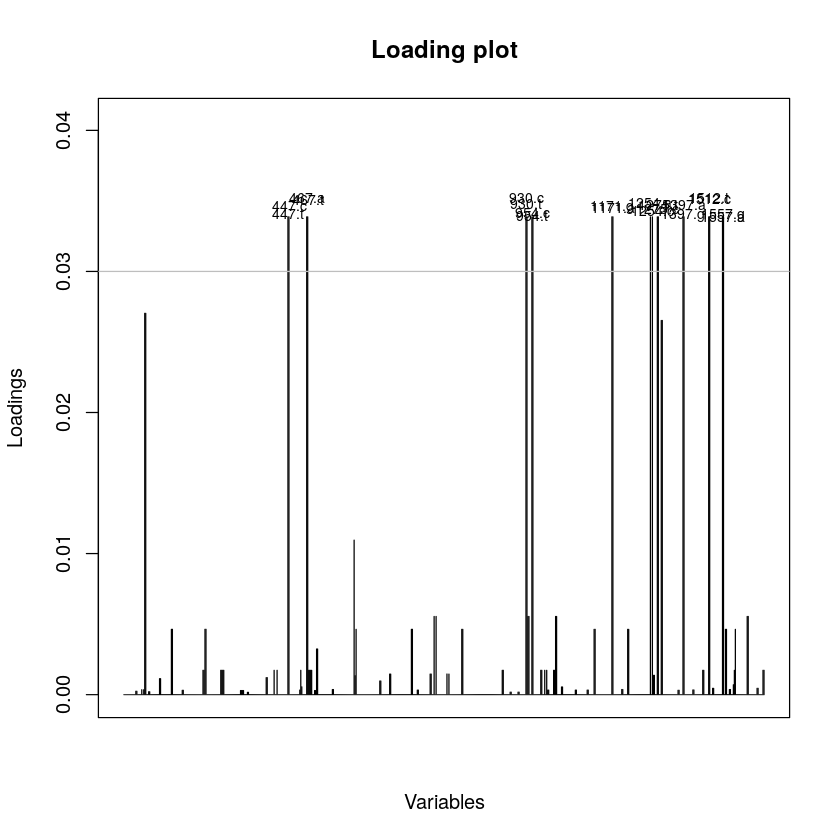

In [152]:
contrib <- loadingplot(dapc_h3n2_mini$var.contr, axis = 1, thres = 0.03, lab.jitter = 1)

In [153]:
head(sort(dapc_h3n2_mini$var.contr[,1],decreasing=TRUE))

447.t      447.c      467.a      467.t      930.t      930.c 
0.03386577 0.03386577 0.03386577 0.03386577 0.03386577 0.03386577

Now we plot the allele frequencies of the position "447" as a function of time:

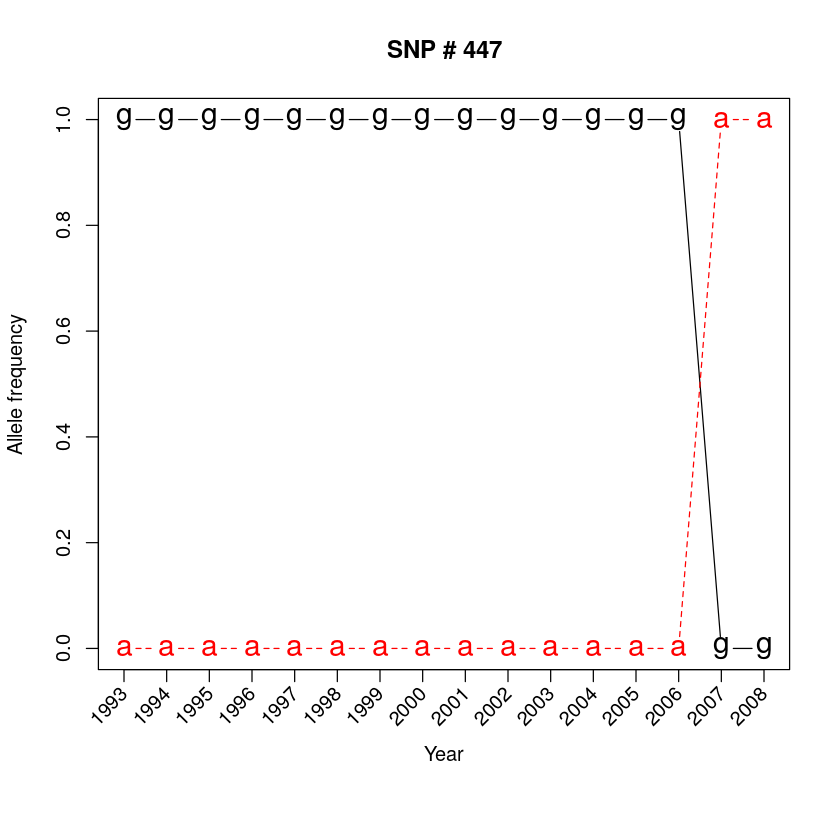

In [154]:
temp    <- seploc(h3n2)  
snp447  <- tab(temp[["447"]])
freq197 <- apply(snp447, 2, function(e) tapply(e, pop(h3n2), mean, na.rm = TRUE))
                 par(mar = c(7, 4, 4, 2) + 0.1)
matplot(freq197,  pch = c("g", "a"), type = "b",
        xlab = "Year", ylab = "Allele frequency", main = "SNP # 447",
        xaxt = "n", cex = 1.5)
axis(side = 1, at=1:16, labels=FALSE)
text(1:16,par("usr")[3] - 0.04, srt = 45, adj = 1,
     labels = 1993:2008, xpd = TRUE)